# Model Interpretation and Error Analysis

This notebook focuses on interpreting the behavior of the churn prediction model
developed in Notebook 02. Beyond overall performance metrics, we analyze
decision thresholds, misclassified examples, and model limitations.

## Imports

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

## Load and Prepare Data

In [55]:
df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
df = df.dropna()

X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"]


## Train-Test Split

The dataset is split into training and test sets to enable unbiased evaluation
of model behavior on unseen data.


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Preprocessing

The same preprocessing pipeline as in Notebook 02 is reused to ensure consistency
between model training and interpretation.


In [57]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "string"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


## Logistic Regression Model

A logistic regression model is trained to analyze probability outputs and
decision boundaries in a transparent manner.


In [58]:
log_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("logisticregression", LogisticRegression(max_iter=1000))
    ]
)

log_reg.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('logisticregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different tr

## ROC Curve Analysis

The ROC curve visualizes the trade-off between true positive rate and false
positive rate across different classification thresholds.


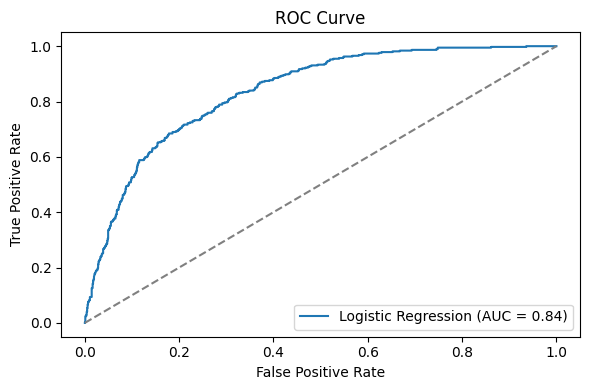

In [59]:
y_scores = log_reg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_scores)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


## Error Analysis

To better understand the limitations of the model, we analyze cases where the
predictions differ from the true labels.


In [60]:
results = X_test.copy()
results["y_true"] = y_test.values
results["y_score"] = y_scores
results["y_pred"] = (y_scores >= 0.5).astype(int)

false_positives = results[(results["y_pred"] == 1) & (results["y_true"] == 0)]
false_negatives = results[(results["y_pred"] == 0) & (results["y_true"] == 1)]

false_positives.head(), false_negatives.head()


(      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 619   Female              0      No         No       7          Yes   
 4283    Male              1     Yes         No       4          Yes   
 6128  Female              0     Yes         No      14          Yes   
 2968    Male              0      No         No       3          Yes   
 3612    Male              0      No         No      21          Yes   
 
      MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
 619            Yes     Fiber optic             No          Yes  ...   
 4283            No     Fiber optic             No           No  ...   
 6128            No     Fiber optic             No           No  ...   
 2968            No     Fiber optic             No          Yes  ...   
 3612           Yes     Fiber optic             No           No  ...   
 
      StreamingTV StreamingMovies        Contract PaperlessBilling  \
 619           No              No  Month-to-month             

### Interpretation of Misclassified Examples

- False positives often correspond to customers with high monthly charges but
  long tenure, suggesting competing risk factors.
- False negatives frequently include customers with short tenure but multiple
  subscribed services, which may partially offset churn risk.
- These observations highlight the linear assumptions of logistic regression
  and suggest that certain feature interactions are not fully captured.


## SHAP-Based Interpretation (Advanced)

While logistic regression coefficients provide a global and linear view of feature
importance, they do not capture instance-level contributions.

SHAP (SHapley Additive exPlanations) is used here as a model-agnostic method to
analyze how individual features contribute to churn predictions.


In [61]:
import shap

## Preparing Data for SHAP Analysis

SHAP requires access to the transformed feature space.
We therefore apply the preprocessing step separately.


In [62]:
import shap

# Transform test data using the fitted preprocessor
X_test_transformed = log_reg.named_steps["preprocessor"].transform(X_test)

# Extract feature names and classifier
feature_names = log_reg.named_steps["preprocessor"].get_feature_names_out()
classifier = log_reg.named_steps["logisticregression"]

# Use training data as SHAP background (masker)
X_train_transformed = log_reg.named_steps["preprocessor"].transform(X_train)
masker = shap.maskers.Independent(X_train_transformed)

# Create SHAP explainer (new API)
explainer = shap.LinearExplainer(
    classifier,
    masker
)

# Compute SHAP values
shap_values = explainer(X_test_transformed)



## Global Feature Importance (SHAP)

The SHAP summary plot highlights which features contribute most to churn
predictions across the dataset.


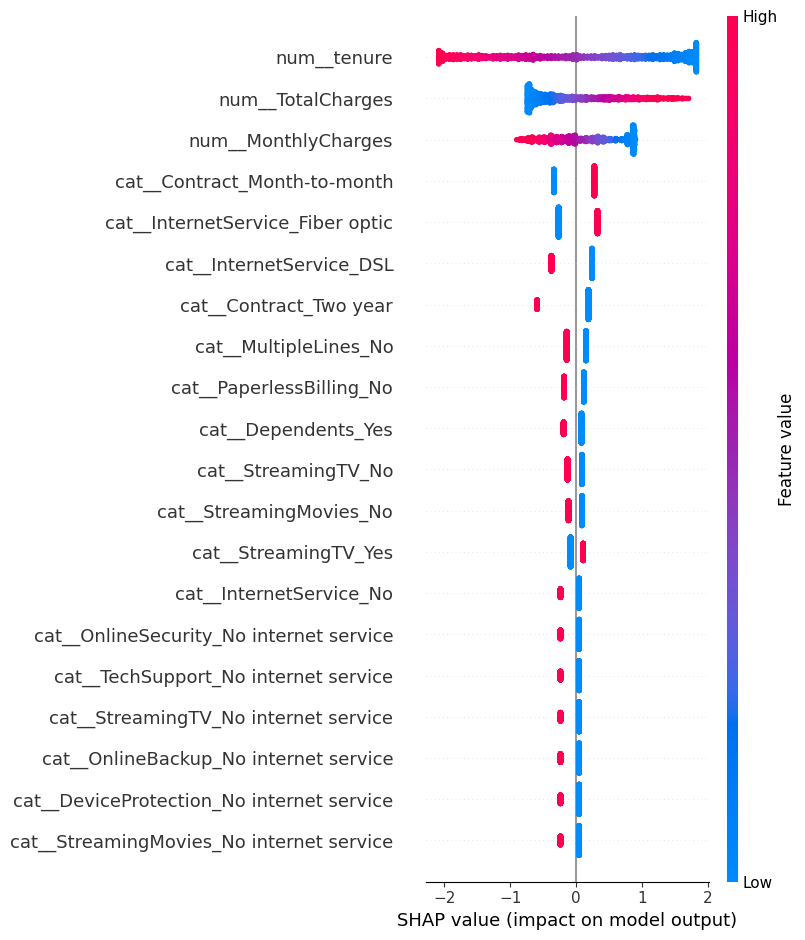

In [63]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    show=True
)


In [64]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

shap_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap
    })
    .sort_values(by="mean_abs_shap", ascending=False)
)

shap_importance.head(10)


,feature,mean_abs_shap
1,num__tenure,1.219034
3,num__TotalCharges,0.562903
2,num__MonthlyCharges,0.462429
36,cat__Contract_Month-to-month,0.303149
16,cat__InternetService_Fiber optic,0.291296
15,cat__InternetService_DSL,0.286727
38,cat__Contract_Two year,0.281115
12,cat__MultipleLines_No,0.146791
39,cat__PaperlessBilling_No,0.144768
9,cat__Dependents_Yes,0.112996


### Key Explainability Insights

- Contract type and monthly charges are the strongest global drivers of churn,
  with month-to-month contracts significantly increasing churn risk.
- Longer customer tenure consistently reduces churn probability, indicating
  the stabilizing effect of long-term engagement.
- Add-on services such as online security and tech support contribute negatively
  to churn, suggesting their role in customer retention.
- SHAP explanations reveal that while some effects are global, feature impact
  can vary substantially across individual customers.


**Methodological Note**

We use an Independent masker for SHAP explanations, assuming conditional
independence between features after preprocessing. While this is a simplifying
assumption, it provides a reasonable trade-off between interpretability and
computational efficiency for linear models.
